In [67]:
import numpy as np
import pandas as pd
import mne
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from lightgbm import LGBMClassifier
import lightgbm
from scipy.stats import zscore
from datetime import datetime
import xgboost as xgb
from visbrain.io.rw_hypno import read_hypno
from ipynb.fs.defs.yasa_model import calc_features, get_metrics
import joblib
from IPython.display import clear_output
from sklearn.feature_selection import VarianceThreshold
plt.style.use('dark_background')
pd.options.display.precision = 10

In [108]:
# joblib_file = 'lgbm_model_multichannel.pkl'
model = joblib.load('forest_full_7s.pkl')
# model = joblib.load('lgbm_full_7s.pkl')
features_names = pd.read_csv('features_7.csv').columns.tolist()

In [69]:
####################
# MAIN PARAMETERS
####################

# # Bandpass filter
# freq_broad = (0.1, 500)
# # FFT & bandpower parameters
sr = 1000
edf_path = 'C:\\UCLA\\P%s_full_filtered.edf'
# edf_path = 'C:\\Users\\user\\PycharmProjects\\pythonProject\\%s_clean.edf'
# edf_path = 'C:\\UCLA\\P%s_overnightData.edf'
# bands = [
#     (0.1, 4, 'delta'), (4, 8, 'theta'),
#     (8, 12, 'alpha'), (12, 16, 'sigma'), (16, 30, 'beta'),
#     (30, 75, 'gamma'), (75, 300, 'fast')
# ]

In [109]:
def remove_rem(raw, edf):
    hypno_file = edf.split('_')[0] + '_hypno.txt'

    # read hypnogram old format (1sec)
    hypno, sf_hypno = read_hypno(hypno_file, time=None, datafile=None)

    # make raw object into epochs (30 sec)
    dummy_events = mne.make_fixed_length_events(raw, id=1, duration=30)[:len(hypno)]

    # incorporate the scoring into the events file:
    dummy_events[:, 2] = hypno
    event_dict = {'W': 0, 'N1': 1, 'N2': 2, 'N3': 3, 'REM': 4, 'art': -1}

    # epoch data into 30sec pieces:
    epochs = mne.Epochs(raw, events=dummy_events, event_id=event_dict, tmin=0,
                        tmax=30, baseline=(0, 0), on_missing='ignore')
    epochs.drop(epochs['REM'].selection)
    nrem_raw = mne.io.RawArray(np.concatenate(epochs.get_data(), axis=1), raw.info)

    return nrem_raw

def format_raw_night(edf, channel):
    epochs = []
    window_size = int(sr / 4)
    if '-' in channel and 'REF' not in channel:
        chans = channel.split('-')
        raw = mne.io.read_raw_edf(edf).pick_channels(chans).resample(sr)
        # raw = remove_rem(raw, edf)
        mne.set_bipolar_reference(raw, chans[0], chans[1], ch_name=channel)
        raw_data = raw.get_data()[0]
    else:
        raw_data = mne.io.read_raw_edf(edf).pick_channels([channel]).resample(sr).get_data()[0]
    for i in range(0, len(raw_data), window_size):
        curr_block = raw_data[i: i  + window_size]
        if i + window_size < len(raw_data):
            epochs.append(curr_block)
    return np.array(epochs)
    # return zscore(np.array(epochs))

def format_combine_channel(edf, chans=['PZ' ,'C3' ,'C4']):
    epochs = []
    window_size = int(sr / 4)

    raw = mne.io.read_raw_edf(edf).pick_channels(chans).resample(sr)
    raw = mne.channels.combine_channels(raw, {'avg': [0, 1, 2]}, method='mean')
    raw_data = raw.get_data()[0]

    for i in range(0, len(raw_data), window_size):
        curr_block = raw_data[i: i  + window_size]
        if i + window_size < len(raw_data):
            epochs.append(curr_block)
    return np.array(epochs)


In [110]:
def get_all_y_multi_channel(subjects=['38', '396', '398', '402', '406', '415', '416']):
    neighbors = {'R': ['RAH1-RAH2', 'RA1'], 'L': ['LAH1-LAH2', 'LA1']}
    side1_y = None
    y_all = np.empty(0)
    for subj in subjects:
        # for subj in ['398']:
        for channel in ['RAH1', 'LAH1']:
            if not ((subj == '396' and channel == 'RAH1') or (subj == '38' and channel == 'LAH1')):
                x = format_raw_night(edf_path % subj, channel)
                features = calc_features(x, subj)
                for neighbor in neighbors[channel[0]]:
                    x_neighbor = format_raw_night(edf_path % subj, neighbor)
                    prefix = neighbor.replace(channel[0], '')
                    features_neighbor = calc_features(x_neighbor, subj).add_prefix(f'{prefix}_')
                    features = pd.concat([features, features_neighbor.iloc[:, 2:]], axis=1)

                # Here I have all features for one side
                if side1_y is None:
                    side1_y = model.predict(features[features_names[1:]])

        if subj in ['38', '396']:
            y_all = np.concatenate((y_all, side1_y))
        else:
            side2_y = model.predict(features[features_names[1:]])
            y_bilateral = side1_y + side2_y
            y_bilateral[y_bilateral == 2] = 1
            y_all = np.concatenate((y_all, y_bilateral))

        side1_y = None

    return y_all

def get_all_y_multi_channel_side(side, subjects=['38', '396', '398', '402', '406', '415', '416']):
    neighbors = {'R': ['RAH1-RAH2', 'RA1'], 'L': ['LAH1-LAH2', 'LA1']}
    y_all = np.empty(0)
    for subj in subjects:
        channel = side + 'AH1'
        if not ((subj == '396' and channel == 'RAH1') or (subj == '38' and channel == 'LAH1')):
            x = format_raw_night(edf_path % subj, channel)
            features = calc_features(x, subj)
            for neighbor in neighbors[channel[0]]:
                x_neighbor = format_raw_night(edf_path % subj, neighbor)
                prefix = neighbor.replace(channel[0], '')
                features_neighbor = calc_features(x_neighbor, subj).add_prefix(f'{prefix}_')
                features = pd.concat([features, features_neighbor.iloc[:, 2:]], axis=1)

            side1_y = model.predict(features[features_names[1:]])
            y_all = np.concatenate((y_all, side1_y))

    return y_all

def get_one_y_multi_channel_side(subj, side):
    neighbors = {'R': ['RAH1-RAH2', 'RA1'], 'L': ['LAH1-LAH2', 'LA1']}
    channel = side + 'AH1'
    if not ((subj == '396' and channel == 'RAH1') or (subj == '38' and channel == 'LAH1')):
        x = format_raw_night(edf_path % subj, channel)
        features = calc_features(x, subj)
        for neighbor in neighbors[channel[0]]:
            x_neighbor = format_raw_night(edf_path % subj, neighbor)
            prefix = neighbor.replace(channel[0], '')
            features_neighbor = calc_features(x_neighbor, subj).add_prefix(f'{prefix}_')
            features = pd.concat([features, features_neighbor.iloc[:, 2:]], axis=1)

        side1_y = model.predict(features[features_names[1:]])

    return side1_y

def get_all_feat_eog(eog_num, subjects=['38', '396', '398', '402', '406', '415', '416']):
    feat_all = pd.DataFrame()
    for subj in subjects:
        x = format_raw_night(edf_path % subj, 'EOG' + eog_num)
        features = calc_features(x, subj)
        # normalize each subject with respect to self
        # features=(features-features.mean())/features.std()
        # features.apply(zscore)
        feat_all = pd.concat([feat_all, features], axis=0)

    return feat_all

def get_all_feat_by_chan(chan, subjects=['38', '396', '398', '402', '406', '415', '416']):
    feat_all = pd.DataFrame()
    for subj in subjects:
        x = format_raw_night(edf_path % subj, chan)
        features = calc_features(x, subj)
        # normalize each subject with respect to self
        # features=(features-features.mean())/features.std()
        # features.apply(zscore)
        feat_all = pd.concat([feat_all, features], axis=0)

    return feat_all

def get_all_feat_scalp_channels(channels=['C3', 'C4', 'PZ'], subjects=['38', '396', '398', '402', '406', '415', '416']):
    feat_all = pd.DataFrame()
    for subj in subjects:
        channel = channels[0]
        x = format_raw_night(edf_path % subj, channel)
        features = calc_features(x, subj)
        for neighbor in channels[1:]:
            x_neighbor = format_raw_night(edf_path % subj, neighbor)
            prefix = neighbor.replace(channel[0], '')
            features_neighbor = calc_features(x_neighbor, subj).add_prefix(f'{prefix}_')
            features = pd.concat([features, features_neighbor.iloc[:, 2:]], axis=1)

        feat_all = pd.concat([feat_all, features], axis=0)

    return feat_all

def get_all_feat_avg_channels(subjects=['38', '396', '398', '402', '406', '415', '416']):
    feat_all = pd.DataFrame()
    for subj in subjects:
        x = format_combine_channel(edf_path % subj)
        features = calc_features(x, subj)
        feat_all = pd.concat([feat_all, features], axis=0)

    return feat_all

In [115]:
def plt_80(cls, feat, y, stratify=False):
    if stratify:
        strat = pd.DataFrame()
        strat['y'] = list(map(str, y))
        strat['subj'] = list(feat['subj'])
        strat['stratify'] = strat[['y', 'subj']].apply(lambda x: ''.join(x), axis=1)
        X_train, X_test, y_train, y_test = train_test_split(feat, y, stratify=strat['stratify'], random_state=20)
    else:
        X_train, X_test, y_train, y_test = train_test_split(feat, y, stratify=y, random_state=20)
    X_train_data = X_train.iloc[:, 2:]
    selector = VarianceThreshold(.1)
    selector.fit_transform(X_train_data)
    X_train_data = X_train_data[X_train_data.columns[selector.get_support(indices=True)]]
    X_test_data = X_test[X_train_data.columns]

    f, axes = plt.subplots(1, len(cls), figsize=(10, 5), sharey='row')
    pred_details = {}

    for i, (key, classifier) in enumerate(cls.items()):
        y_pred = classifier.predict_proba(X_test_data).T
        cf_matrix = confusion_matrix(y_test, [p > 0.80 for p in y_pred[1]])
        metrics = get_metrics(cf_matrix)
        disp = ConfusionMatrixDisplay(cf_matrix)
        disp.plot(ax=axes[i], xticks_rotation=45)
        precision = '{0:.2f}'.format(metrics['precision'])
        recall = '{0:.2f}'.format(metrics['recall'])
        text = """precision: {0}
                          recall: {1}""".format(precision, recall)
        axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                         xytext=(-60, -40), textcoords='offset points',
                         ha='right', va='top')
        disp.ax_.set_title(key)
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        if i != 0:
            disp.ax_.set_ylabel('')

        curr_pred_details = pd.DataFrame(data=X_test)
        curr_pred_details['pred'] = y_pred[1]
        pred_details[key] = curr_pred_details

    f.text(0.45, 0.1, 'Predicted label', ha='left')
    plt.subplots_adjust(wspace=0.40, hspace=0.1)
    plt.show()
    return pred_details

def plt_cls(feat, y, stratify=False):
    if stratify:
        strat = pd.DataFrame()
        strat['y'] = list(map(str, y))
        strat['subj'] = list(feat['subj'])
        strat['stratify'] = strat[['y', 'subj']].apply(lambda x: ''.join(x), axis=1)
        X_train, X_test, y_train, y_test = train_test_split(feat, y, stratify=strat['stratify'], random_state=20)
    else:
        X_train, X_test, y_train, y_test = train_test_split(feat, y, stratify=y, random_state=20)
    X_train_data = X_train.iloc[:, 2:]
    selector = VarianceThreshold(.1)
    selector.fit_transform(X_train_data)
    X_train_data = X_train_data[X_train_data.columns[selector.get_support(indices=True)]]
    X_test_data = X_test[X_train_data.columns]

    classifiers_2_all = {
        "Random Forest": RandomForestClassifier(),
        "LGBM": LGBMClassifier(),
        # "XGB": xgb.XGBClassifier(objective="multi:softmax", num_class=2, use_label_encoder=False),
    }

    pred_details = {}
    f, axes = plt.subplots(1, len(classifiers_2_all), figsize=(10, 5), sharey='row')

    for i, (key, classifier) in enumerate(classifiers_2_all.items()):
        y_pred = classifier.fit(X_train_data, y_train).predict(X_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
        metrics = get_metrics(cf_matrix)
        disp = ConfusionMatrixDisplay(cf_matrix)
        disp.plot(ax=axes[i], xticks_rotation=45)
        precision = '{0:.2f}'.format(metrics['precision'])
        recall = '{0:.2f}'.format(metrics['recall'])
        text = """precision: {0}
                  recall: {1}""".format(precision, recall)
        axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                         xytext=(-60, -40), textcoords='offset points',
                         ha='right', va='top')
        disp.ax_.set_title(key)
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        if i != 0:
            disp.ax_.set_ylabel('')
        curr_pred_details = pd.DataFrame(data=X_test)
        curr_pred_details['pred'] = y_pred
        pred_details[key] = curr_pred_details

    f.text(0.45, 0.1, 'Predicted label', ha='left')
    plt.subplots_adjust(wspace=0.40, hspace=0.1)
    plt.show()
    return classifiers_2_all, pred_details

In [91]:
# run all subj (~15min, 6 subj)
y_all_bi = get_all_y_multi_channel()
clear_output()
feat_avg = get_all_feat_avg_channels()
# feat_all_eog1 = get_all_feat_eog('1')
feat_all_eog2 = get_all_feat_eog('2')
# feat_all_eog_bi = pd.concat([feat_all_eog1.add_suffix('_1'), feat_all_eog2.iloc[:, 2:].add_suffix('_2')], axis=1)
feat_avg.reset_index(inplace=True, drop=True)
feat_all_eog2.reset_index(inplace=True, drop=True)
feat_eog2_avg = pd.concat([feat_avg, feat_all_eog2.iloc[:, 2:].add_suffix('_2')], axis=1)
clear_output()

In [ ]:
feat_pz = get_all_feat_by_chan('PZ')
# feat_c3 = get_all_feat_chan('C3')
# feat_c4 = get_all_feat_chan('C4')
# clear_output()

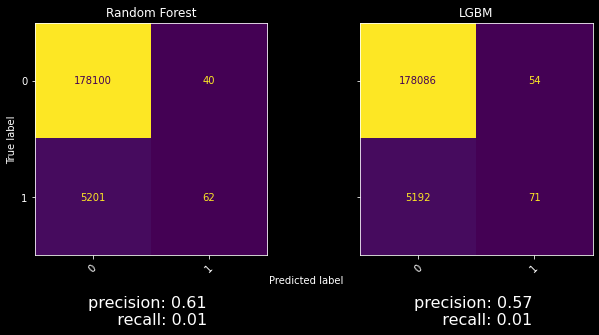

In [113]:
cls_all, pred_details = plt_cls(feat_pz, y_all_bi, stratify=True)

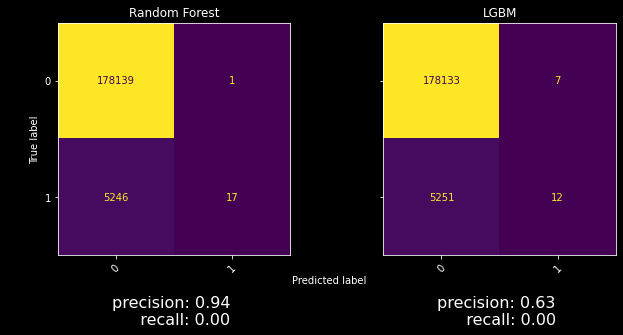

In [116]:
pred_details_80 = plt_80(cls_all, feat_pz, y_all_bi, stratify=True)

In [ ]:
# read all subj
y_all_bi = np.load('y_all_ff_bi.npy')
feat_all_eog1 = pd.read_pickle('feat_all_eog1.pkl')
feat_all_eog2 = pd.read_pickle('feat_all_eog2.pkl')
feat_all_eog_bi = pd.concat([feat_all_eog1.add_suffix('_1'), feat_all_eog2.iloc[:, 2:].add_suffix('_2')], axis=1)
clear_output()

In [119]:
# save stuff
# np.save('y_all_ff_bi.npy', y_all_bi)
# feat_all_eog1.to_pickle('feat_all_eog1.pkl')

In [50]:
feat_all_scalp = get_all_feat_channels()
clear_output()

In [65]:
y_all_right = get_all_y_multi_channel_side('R')
y_all_left = get_all_y_multi_channel_side('L')
clear_output()

In [140]:
# plt.rcParams["figure.figsize"] = (15,7)
# lightgbm.plot_importance(jl_model)

In [ ]:
prob = pd.DataFrame(classifiers['LGBM'].predict_proba(X_test))
prob[prob[0] < 0.99].sort_values(by=prob.columns[1])[1].hist()

In [ ]:
# health_raw = mne.io.read_raw_egi('/Users/rotemfalach/Downloads/MG4_sleep2_20190503_125004.mff')
health_raw = mne.io.read_raw_egi('C:\\PAT\\AH8_SLEEP_20201125_155835.mff')
# this is the  left set referenced to RM, while EOG referenced to LM
selected_set = [['E226', 'E46', 'E104', 'E35', 'E59', 'E116', 'E201'],
                ['EOG E1-LM', 'EOG E2-LM', 'LM', 'EEG F3-RM', 'EEG C3-RM', 'EEG O1-RM', 'RM']]
health_raw.pick_channels(selected_set[0]).resample(sr)
# order channels according to selected set, MNE default is alphabetical
health_raw.reorder_channels(selected_set[0])

# rename channels
health_raw.rename_channels({id: name for (id, name) in zip(selected_set[0], selected_set[1])})
# set EOG channels as MNE type "ecog" for re-refrencing
health_raw.set_channel_types({selected_set[1][i]: 'ecog' for i in range(2)})
# re-reference channels
health_raw.set_eeg_reference(ref_channels=[selected_set[1][2]], ch_type='ecog')
health_raw.set_channel_types({selected_set[1][i]: 'eog' for i in range(2)})
health_raw.drop_channels([selected_set[1][2], selected_set[1][6]])

In [178]:
health_raw

In [46]:
epochs = []
health_data = health_raw.pick_channels(['EOG E2-LM']).get_data()[0]
window_size = 250
for i in range(0, len(health_data), window_size):
    curr_block = health_data[i: i  + window_size]
    if i + window_size < len(health_data):
        epochs.append(curr_block)
epochs = np.array(epochs)

feat_healthy_eye = calc_features(epochs)
y_healthy_pred = classifiers['LGBM'].predict(feat_healthy_eye)

c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\scipy\signal\spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  .format(nperseg, input_length))


ValueError: Number of features of the model must match the input. Model n_features_ is 66 and input n_features is 63

In [ ]:
# i_pred = X_test[y_pred == 1].sort_values(by='epoch').index.tolist()
# i_pred.sort()
# for i in i_pred[:20]:
#     fig, axs = plt.subplots(3, figsize=(4, 4))
#     axs[0].set_title(i)
#     pred_view = np.concatenate(x_AH[i - 2: i + 3])
#     axs[0].plot(pred_view)
#     axs[0].plot(range(500, 750), x_AH[i], c='red')
#     pred_view = np.concatenate(x_bi[i - 2: i + 3])
#     axs[2].plot(pred_view)
#     axs[2].plot(range(500, 750), x_bi[i], c='black')
#     pred_view = np.concatenate(x_A[i - 2: i + 3])
#     axs[1].plot(pred_view)
#     axs[1].plot(range(500, 750), x_A[i], c='green')

In [192]:
pred_details['Random Forest']

,subj,epoch_id,std,iqr,skew,kurt,nzc,hmob,hcomp,theta,...,at_pmin_norm_2,gt_pmin_norm_2,ft_pmin_norm_2,ag_pmin_norm_2,af_pmin_norm_2,abspow_pmin_norm_2,perm_pmin_norm_2,higuchi_pmin_norm_2,petrosian_pmin_norm_2,pred
23240,402,23240,0.0000061805,0.0000075643,0.9043173818,-0.3731787874,3,0.0423529503,4.2800305518,0.5429664511,...,0.2645690743,-0.0638160215,-0.1207882743,-0.0799799096,-0.1765310793,0.5403751808,-0.1934291748,-0.1128452484,-0.3068614195,0
3160,396,3160,0.0000015439,0.0000014184,1.2441867937,2.8720089154,1,0.0885457408,4.0280318501,0.2986484320,...,-0.1012437133,0.2246993063,0.2958636940,0.3112901272,0.3783851142,-0.1466988235,0.3952240036,0.2303743386,0.4255226684,0
66123,406,66123,0.0000113751,0.0000174620,0.6558363180,-0.9007563222,3,0.0466058011,2.9958969500,0.5193868697,...,0.3819044301,-0.0289513737,-0.0862293586,-0.0411525961,-0.0117236570,0.2800988129,0.0140576637,0.1340014094,0.0499600248,0
67080,406,67080,0.0000144562,0.0000265708,0.0766952076,-1.3312275436,3,0.0388921002,2.9789513262,0.6251846699,...,0.4051571890,-0.0369814968,0.3431210163,-0.0602406452,0.1373595454,-0.1384635840,0.5474291148,0.0633132832,0.6778949435,0
33942,416,33942,0.0000160657,0.0000257005,-0.7877683070,-0.8680450799,3,0.0372607046,2.4768767475,0.6232854062,...,-0.1516864810,0.3012074164,-0.0692659259,0.3760420507,-0.0496499390,0.2171681939,0.0304982949,-0.2225433291,-0.0136032034,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54993,416,54993,0.0000283590,0.0000575902,-0.2651708552,-1.5181737549,0,0.0321858028,2.5324087236,0.7895380142,...,-0.1960620407,-0.1117743548,-0.1378050342,-0.1161920907,-0.1534598601,0.5412905042,-0.2784039606,0.0985758979,-0.1745302021,0
11996,402,11996,0.0000064861,0.0000102593,-0.7229266879,-0.9711183663,4,0.0240940966,12.6296137546,0.8588380423,...,0.2507096879,0.5513401968,0.9792089970,0.2340487241,0.3945459644,0.4358849056,-0.0532248622,-0.1494672468,0.0919514509,0
40838,398,40838,0.0000063683,0.0000071969,1.0122663829,0.4029225544,3,0.0307351829,7.1365384256,0.6609515663,...,0.1455676836,0.0319967697,0.5084866915,-0.0059247001,0.2553098439,-0.0113539616,-0.1952777094,-0.1599477270,0.1573219860,0
69724,415,69724,0.0000177436,0.0000232742,0.2568682451,-0.3455045616,5,0.0544904173,1.6602074105,0.2939775346,...,0.2763069495,0.4486608213,-0.1435390011,0.1586304505,-0.1775994554,1.1745734530,-0.3772368067,-0.0324116335,-0.3827457981,0


In [51]:
feat_all_eog_bi = pd.concat([feat_all_eog1.add_suffix('_1'), feat_all_eog2.iloc[:, 2:].add_suffix('_2')], axis=1)
feat_all_scalp_eog = pd.concat([feat_all_eog_bi, feat_all_scalp.iloc[:, 2:]], axis=1)

In [ ]:
pred_epochs = pred_details[(pred_details['subj'] == '402') & (pred_details['pred'] ==1 )].epoch_id.tolist()
pred_epochs.sort()

[15:09:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


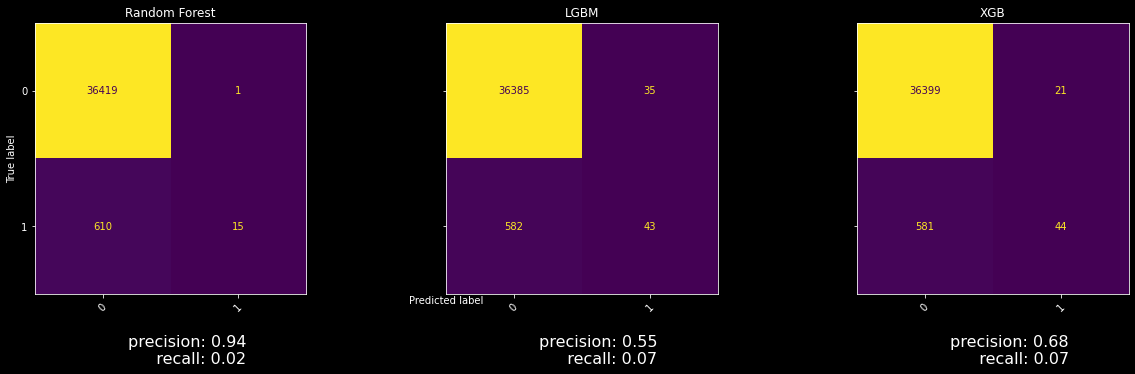

In [102]:
subj = '38'
y_bi_416 = get_all_y_multi_channel([subj])
# y_r = get_all_y_multi_channel_side('R', [subj])
# y_l = get_all_y_multi_channel_side('L', [subj])
feat_eog1_416 = get_all_feat_eog('1', [subj])
feat_eog2_416 = get_all_feat_eog('2', [subj])
feat_eog_bi_416 = pd.concat([feat_eog1_416.add_suffix('_1'), feat_eog2_416.add_suffix('_2')], axis=1)
clear_output()
cls_416_bi, pred_416 = plt_cls(feat_eog_bi_416, y_bi_416)

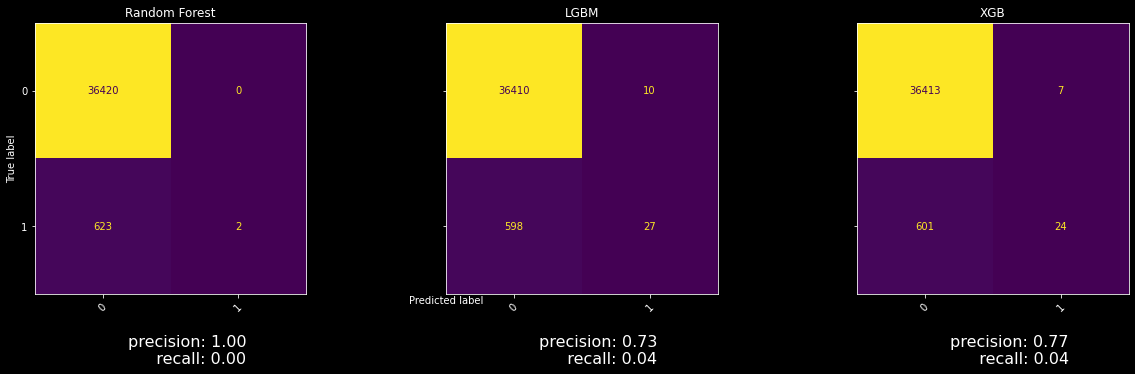

In [103]:
pred_416_80 = plt_80(cls_416_bi, feat_eog_bi_416, y_bi_416)

In [ ]:
# before calling to calc feat, per row/col, sub mean from all for center, minmax or z score, per channel or per epoch
# copy hist, remove XGB?, save results 7, use forest for detection

In [107]:
details = pred_details['Random Forest']
details[(details['pred'] ==1 )].sort_values(by='subj')[['subj', 'epoch_id']].to_csv('rf_filter_lgbm_scalp_avg_eog2_7.csv')

In [219]:
joblib.dump(pred_details, 'filter_lgbm_scalp_avg_eog2_80.pkl')

['filter_lgbm_scalp_avg_eog2_80.pkl']

In [ ]:
# save depth detection files
for subj in ['38']:
    y_bi = get_all_y_multi_channel([subj])
    spike_index = np.transpose((y_bi == 1).nonzero())
    pd.DataFrame(spike_index).to_csv(f"filter_depth_lgbm_{subj}.csv", header=False, index=False)

<AxesSubplot:>

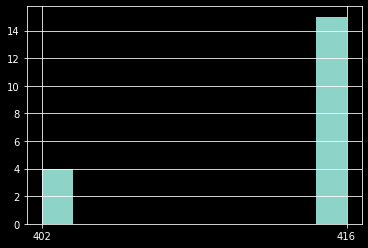

In [121]:
# check detection distribution
details = pred_details_80['Random Forest']
details[(details['pred'] > 0.8)].sort_values(by='subj')['subj'].hist()